In [1]:
#The script requires the csv raw data under the relative path "../data/raw"
#Figures will be saved under "../figures"
#Resulting tables are saved under "../data/metafor"

#Load packages
#
library(ggplot2) 
library(metafor)
library(forestplot)

Loading required package: Matrix
Loading 'metafor' package (version 2.0-0). For an overview 
and introduction to the package please type: help(metafor).
Loading required package: grid
Loading required package: magrittr
Loading required package: checkmate


In [2]:
#Set to True to save all the figures.
save_figures<-FALSE 

#define some util functions. 

test_data<-function(dat,value){
    #Test if there is enough data in a quantile to perform meta-analysis.
    indx<-dat$quantile==value
    return( length(dat[indx,]$Reference)>1 )
}

test_QEE<-function(value){
    #Return a <0 if Q value is negative (for presentation).
    if(value<0)
        {return("<0")}
    return( value )
}

calculate_I2<-function(res_){
    #Calculate I^2 for multi-level analysis.
    #Gives two components of I2: within studies I2 and between studies I2
    W <- diag(1/res_$vi)
    X <- model.matrix(res_)
    P <- W - W %*% X %*% solve(t(X) %*% W %*% X) %*% t(X) %*% W
    return (round(100 * res_$sigma2 / (sum(res_$sigma2) + (res_$k-res_$p)/sum(diag(P))),digits = 2))
}

make_M_label<-function(res_){
    #Returns a formatted M label for the forest plot (meta-analysis). 
    return (paste(round(exp(res_$b),digits = 2)," [",round(exp(res_$ci.lb),digits = 2),",",round(exp(res_$ci.ub),digits = 2),"]"))
}

make_M_label2<-function(res_,factor=10000){
    #Returns a formatted M label for the forest plot (meta-regression). 
    return (paste(round(factor*res_$b[2],digits = 2)," [",round(factor*res_$ci.lb[2],digits = 2),",",round(factor*res_$ci.ub[2],digits = 2),"]"))
}


In [3]:
###################################################################################
#                                   BEGIN
#
# 
# Meta-Analysis for S4 data 
#
#

#declare a vector with input files 
file_list<-c(
    "../data/raw/Yield_t_ha_S4.csv",               
    "../data/raw/Plant_height_cm_S4.csv",
    "../data/raw/Root_weight_g_S4.csv",
    "../data/raw/Soil_water_evaporation_capacity_mm_S4.csv",
    "../data/raw/Soil_water_infiltration_rate_mm_min_S4.csv",
    "../data/raw/SOM_g_kg_S4.csv",
    "../data/raw/Olsen-P_mg_kg_S4.csv"
               )

#declare a vector with data set names 
dataset_name_list<-c(
    "Yield",                   
    "Plant height",
    "Root weight",
    "SW evaporation capacity",
    "SW infiltration rate",
    "SOM",
    "Olsen-P")


append_row_df_s4<-function(df,res,name_v,q_v,issummary)
{
    #append a new row to df_s4 data frame
    I2<-calculate_I2(res)
    return (rbind(df, data.frame(        
            name     =c(name_v),
            q        =c(q_v),
            summary=c(issummary),
    
            b        =c(exp(res$b)),
            I2       =c(sum(I2)),
            I2b      =c(I2[1]),
            I2w      =c(I2[2]),
            vb       =c(exp(res$se**2)),
            lb       =c(exp(res$ci.lb)),
            ub       =c(exp(res$ci.ub)),
            n        =c(res$k),
       
            sigma2_1 =c(res$sigma2[1]),
            sigma2_2 =c(res$sigma2[2]),
            #tau2_se  =c(res$se.tau2),
            QEE      =c(test_QEE(res$QE -(res$k-1))),
            QEp      =c(res$QEp),
            pval     =c(res$pval),

            M_label  =c(make_M_label(res)),
    
            stringsAsFactors = FALSE
            )))
    
}

#create a data.frame where the first row are the name of the columns in the plot 
df_s4 <-data.frame(

name = c(NA),
q= c("Residual film"),
summary = c(TRUE),

b       =c(NA),
I2      =c("I\u00B2 (%)"), #\u00B2 is unicode for superscript 2 
I2b     =c("(between studies) I\u00B2 (%)"), 
I2w     =c("(within studies) I\u00B2 (%)"), 
vb      =c(NA),
lb      =c(NA),
ub      =c(NA),
n     =c("n"),

sigma2_1=c("\u03C3\u00B2 1"), #\u03C3 is unicode for sigma 
sigma2_2=c("\u03C3\u00B2 2"),
#tau2_se =c(NA),
QEE     =c(NA),
QEp     =c(NA),
pval    =c(NA),

M_label =c("Response ratio"),
    
stringsAsFactors = FALSE
)
    
#iterate the data sets 
for(i in 1:7){

    file_name <- file_list[i]

    dataset_name <- dataset_name_list[i]
    
    #Read input datafile 
    df<-read.csv(file=file_name, header=TRUE, sep=",")
    #Calculate  log transformed Ratio Of Means
    dat<-escalc(measure = "ROM",m2i=CKmean,n2i=CKn,sd2i=CKsd,m1i=Tmean,n1i=Tn,sd1i=Tsd,data=df,append = TRUE)
    
    #test for proper size of dataset 
    if(test_data(dat,"49-225")){    
        #calculate random effect multi-level meta-analysis REML
        res.q1 <- rma.mv(yi, vi, data=dat,random = ~1 | Reference/X,method="REML",subset=(quantile=="49-225"))
        df_s4<-append_row_df_s4(df_s4,res.q1,NA,"49-225",FALSE)
    }
    
    #test for proper size of dataset 
    if(test_data(dat,"225-600")){   
        #calculate random effect multi-level meta-analysis REML
        res.q2 <- rma.mv(yi, vi,random = ~1 | Reference/X, data=dat, method="REML",subset=(quantile=="225-600"))
        df_s4<-append_row_df_s4(df_s4,res.q2,NA,"225-600",FALSE)
    }
    
    #test for proper size of dataset 
    if(test_data(dat,"600-2700")){    
        #calculate random effect multi-level meta-analysis REML
        res.q3 <- rma.mv(yi, vi,random = ~1 | Reference/X, data=dat, method="REML",subset=(quantile=="600-2700"))
        df_s4<-append_row_df_s4(df_s4,res.q3,NA,"600-2700",FALSE)
    }
    
    #SUMMARY 
    #calculate random effect multi-level meta-analysis REML
    res.q  <- rma.mv(yi, vi,random = ~1 | Reference/X ,data=dat, method="REML")    
    df_s4<-append_row_df_s4(df_s4,res.q,dataset_name,NA,TRUE)
    
    }

#Save data to a csv file
write.csv(df_s4,paste("../data/metafor/analysis_metafor.csv",sep=""))

Warning message in rma.mv(yi, vi, random = ~1 | Reference/X, data = dat, method = "REML", :
“Single-level factor(s) found in 'random' argument. Corresponding 'sigma2' value(s) fixed to 0.”Warning message in rma.mv(yi, vi, random = ~1 | Reference/X, data = dat, method = "REML", :
“Single-level factor(s) found in 'random' argument. Corresponding 'sigma2' value(s) fixed to 0.”

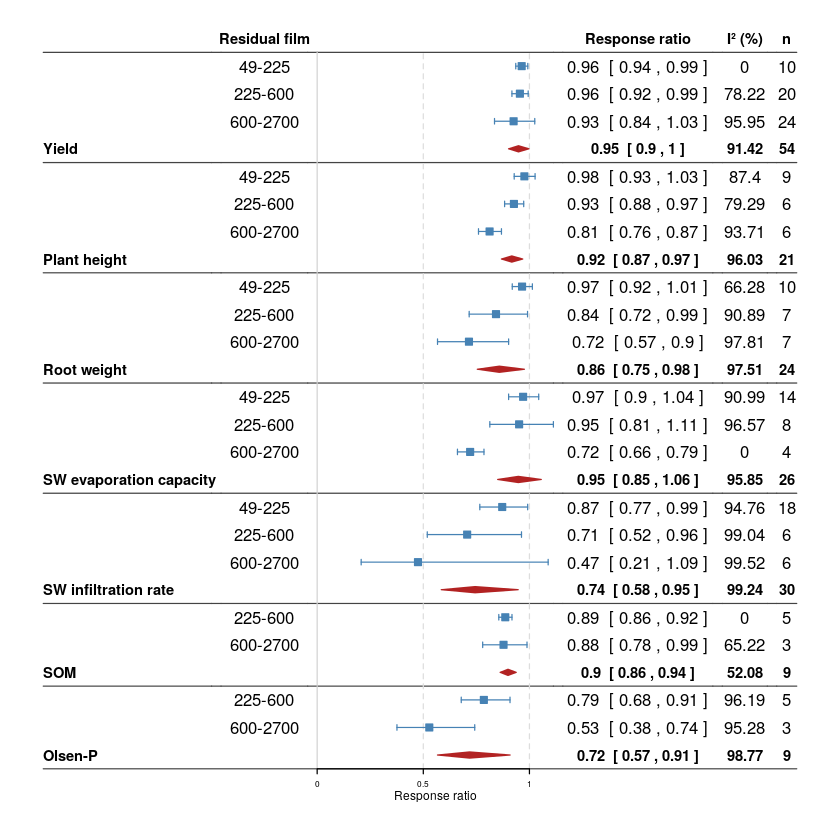

In [4]:
#set save_figures=TRUE to create a pdf file 
if(save_figures){
    pdf("../figures/FigureS4.pdf", width=7, height=10)
}

#make a data frame with mean, lower and upper 95% confidence interval bounds 
forestplot_data <- data.frame(df_s4$b,df_s4$lb,df_s4$ub)

#make table with additional information
tabletext<-cbind(
    c(as.vector(df_s4$name)),
    c(as.vector(df_s4$q)),
    c(as.vector(df_s4$M_label)),
    c(as.vector(df_s4$I2)),
    c(as.vector(df_s4$n))
   )

#create a forest plot 
forestplot(tabletext, 
        forestplot_data,new_page = FALSE,
        hrzl_lines = list("2"=gpar(col="#444444"),
                             "6"=gpar(col="#444444"),
                             "10"=gpar(col="#444444"),
                             "14"=gpar(col="#444444"),
                             "18"=gpar(col="#444444"),
                             "22"=gpar(col="#444444"),
                             "25"=gpar(col="#444444"),
                             "28"=gpar(col="#444444")
                            ),           
           txt_gp = fpTxtGp(label = gpar(fontsize=10),summary=gpar(fontsize=8),xlab=gpar(fontsize=12)),
           graph.pos = 3,
           line.margin = .1, # We need to add this to avoid crowding
           is.summary=c(as.vector(df_s4$summary)),
            boxsize = .25, 
           clip=c(-Inf,Inf), 
           colgap=unit(2,"mm"),
           xlog=FALSE, 
           grid=TRUE,
           xlab=as.character(df_s4$M_label[1]),
            vertices = TRUE,
           graphwidth=unit(50,"mm"),
           col=fpColors(box="#4682B4",line="#4682B4", summary="#B22222")
          )

if(save_figures){
dev.off()
    }


#
# 
# Meta-Analysis for S4 data 
#
#
#                                    END
###################################################################################


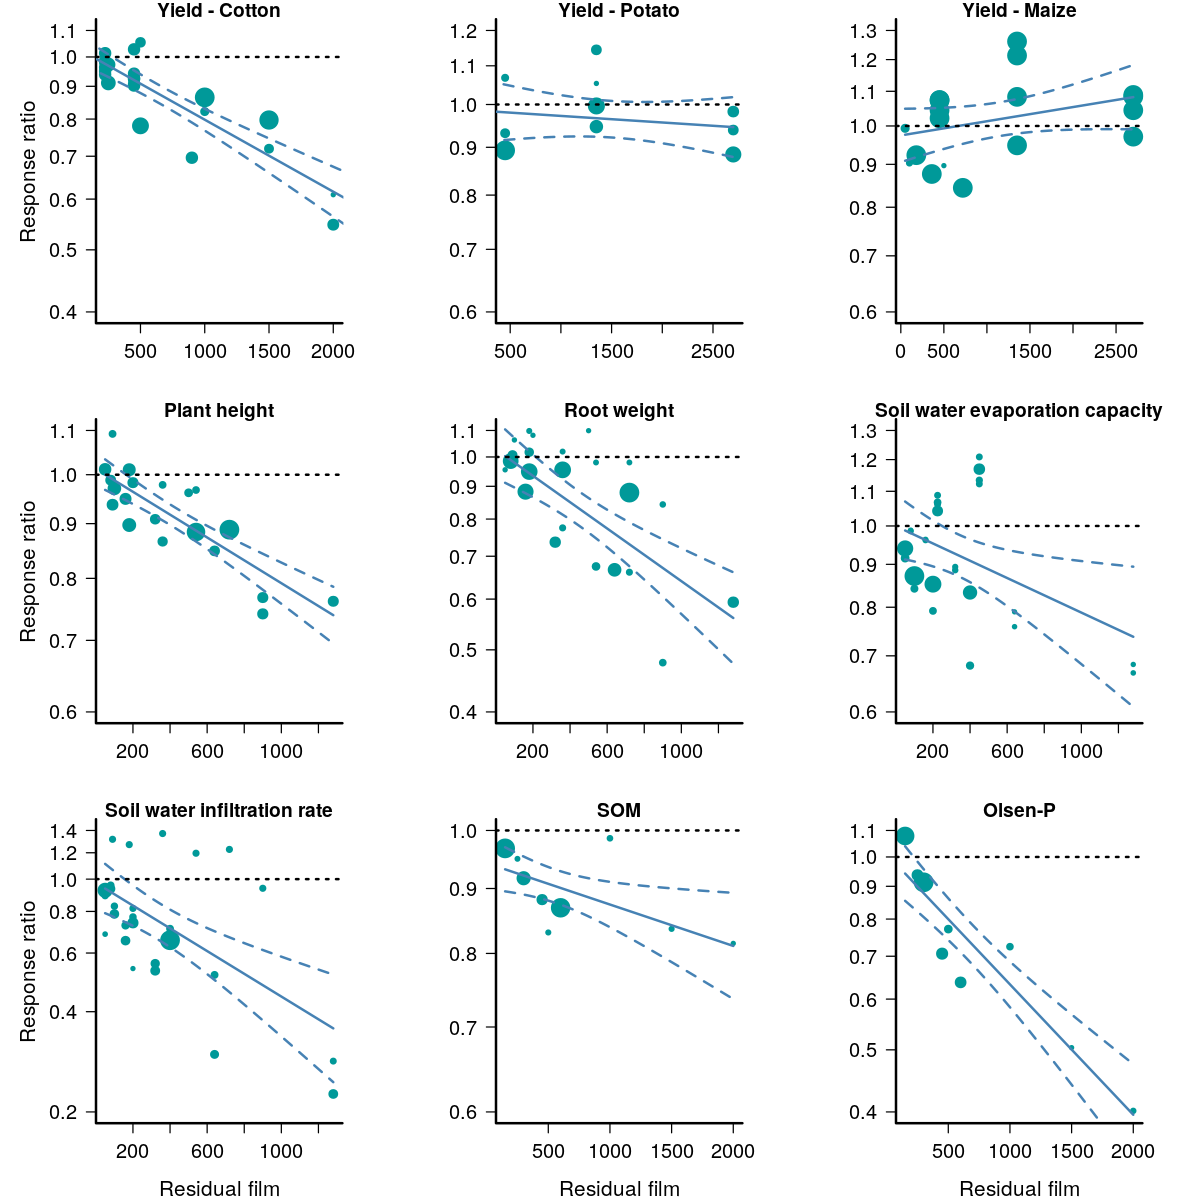

In [5]:
###################################################################################
#                                   BEGIN
#
# 
# Meta-Regression for S4 data 
#
#

#set save_figures=TRUE to create a pdf file 
if(save_figures){
    pdf("../figures/Figure3.pdf", width=10, height=10)
    }
#make a square plot 10x10
options(repr.plot.width=10, repr.plot.height=10)

#plot setup 
#par(mfrow=c(3,3),cex = 0.9,mar=c(4,5,1,2),cex.lab=1.2, cex.axis = 1,lwd=2)
par(mfrow=c(3,3),mar=c(4,5,1,3),lwd=2,cex.lab=1.3,cex.axis = 1.25,cex=0.8)

#create a vector with the name of crop type 
crop_list<-c("Cotton","Potato","Maize","all","all","all","all","all","all")

#declare a vector with data set names
plot_name_list<-c(
    "Yield",               
    "Yield",               
    "Yield",                   
    "Plant height",
    "Root weight",
    "Soil water evaporation capacity",
    "Soil water infiltration rate",
    "SOM",
    "Olsen-P")

#declare a vector with input files 
file_list<-c(
    "../data/raw/Yield_t_ha_S4.csv",
    "../data/raw/Yield_t_ha_S4.csv",               
    "../data/raw/Yield_t_ha_S4.csv",                   
    "../data/raw/Plant_height_cm_S4.csv",
    "../data/raw/Root_weight_g_S4.csv",
    "../data/raw/Soil_water_evaporation_capacity_mm_S4.csv",
    "../data/raw/Soil_water_infiltration_rate_mm_min_S4.csv",
    "../data/raw/SOM_g_kg_S4.csv",
    "../data/raw/Olsen-P_mg_kg_S4.csv"
    )


append_row_regression<-function(df,res,name_v,crop_v,issummary,factor)
{
     #append a new row to df_s4 meta regression data frame
    return (rbind(df, data.frame(
            name= c(name_v),
            crop_data=c(crop_v),
            summary=c(issummary),
            
            b= c(factor*res$b[2]),
            I2= c(round(res$I2,digits = 2)),
            R2= c(round(res$R2,digits = 2)),
            vb     = c(factor*res$vb[2]),
            lb     = c(factor*res$ci.lb[2]),
            ub     = c(factor*res$ci.ub[2]),
            n      = c(res$k),
        
            tau2_se=c(res$se.tau2),
            tau2=c(res$tau2),
            QE= c(res$QE ),
            QEp= c(res$QEp),
            QM= c(res$QM ),
            QMp= c(res$QMp),
            pval= c(res$pval[2]   ),
        
            M_label= c(make_M_label2(res)) ,
            stringsAsFactors = FALSE
            )))
    
}

#create a data.frame where the first row are the name of the columns in the plot 
df_s4_regression <-data.frame(
name     = c(NA),
summary  = c(TRUE),

b        = c(NA),
I2       = c("I\u00B2 (%)"), #\u00B2 is unicode for superscript 2 
R2       = c("R\u00B2 (%)"), 
vb       = c(NA),
lb       = c(NA),
ub       = c(NA),
n        = c("n"),

crop_data=c("Crop"),
tau2_se  = c(NA),
tau2     = c(NA),
QE      = c(NA),
QEp      = c(NA),
QM      = c(NA),
QMp      = c(NA),
pval     = c(NA),

M_label = c("Response gradient (x10\u207B\u2074)"), #\u207B \u2074 is unicode for superscript - and 4
stringsAsFactors = FALSE
)

tics=c(0.2,0.4,0.6,1,1.1,1.2,1.3,1.4)

#iterate the data sets 
for(i in 1:9){

    file_name<-file_list[i]
    crop<-crop_list[i]
    
    #Read input datafile 
    df<-read.csv(file=file_name, header=TRUE, sep=",")
    
    #set an index to filter the crop
    if(crop=="all")
    {
        #if crop == all use the full data set 
        indx<-rep(TRUE,nrow(df))
        plot_name<-paste(plot_name_list[i])
    }
    else{
        indx<-df$Crop_type==crop
        plot_name<-paste(plot_name_list[i],crop,sep=" - ")
    }
    
    #we use x label for the lower rows only 
    xlabel=NA
    if(i >6)
    {
        xlabel<-"Residual film"        
    }
    
    #we use y label for the first column only 
    ylabel=NA
    if(i %in% c(1,4,7))
    {
        ylabel<-"Response ratio"        
    }
    
    
    #Calculate  log transformed Ratio Of Means
    dat<-escalc(measure = "ROM",m2i=CKmean,n2i=CKn,sd2i=CKsd,m1i=Tmean,n1i=Tn,sd1i=Tsd,data=df[indx,],append = TRUE)
        
    #calculate random effect meta-regression ML
    res<-rma(yi,vi,mods=~Residual_film_kg_ha,data=dat,method="ML")
    
    df_s4_regression<-append_row_regression(df_s4_regression,res,plot_name,crop,FALSE,10000)    
    
    #Predict a set of values in the same range of the studies
    preds<-predict(res,newmods = c(min(df$Residual_film_kg_ha):max(df$Residual_film_kg_ha)),transf = exp, digits = 4)
    #claculate proportional weight for the point size
    wi    <- 1/sqrt(dat$vi)
    size  <- 0.4 + 2.0 * (wi - min(wi))/(max(wi) - min(wi))

    max_indx=sum(max(exp(dat$yi))+0.1>tics)
    min_indx=sum(min(exp(dat$yi))>tics)
    
    #scatter plot of the data 
    plot(dat$Residual_film_kg_ha, exp(dat$yi), pch=19, cex=size, 
         xlab=xlabel, ylab=ylabel,col="#009999",
         las=1, bty="l", log="y",main=plot_name,
         ylim=c(tics[min_indx],tics[max_indx]))

    
    #Plot the confidence and mean curves 
    lines(min(df$Residual_film_kg_ha):max(df$Residual_film_kg_ha), preds$pred,col="#4682B4")
    lines(min(df$Residual_film_kg_ha):max(df$Residual_film_kg_ha), preds$ci.lb, lty="dashed",col="#4682B4")
    lines(min(df$Residual_film_kg_ha):max(df$Residual_film_kg_ha), preds$ci.ub, lty="dashed",col="#4682B4")

    
    
    abline(h=1, lty="dotted")
    
    }


#Save data to a csv file
write.csv(df_s4_regression,"../data/metafor/regression.csv")

if(save_figures){
    dev.off()
    }


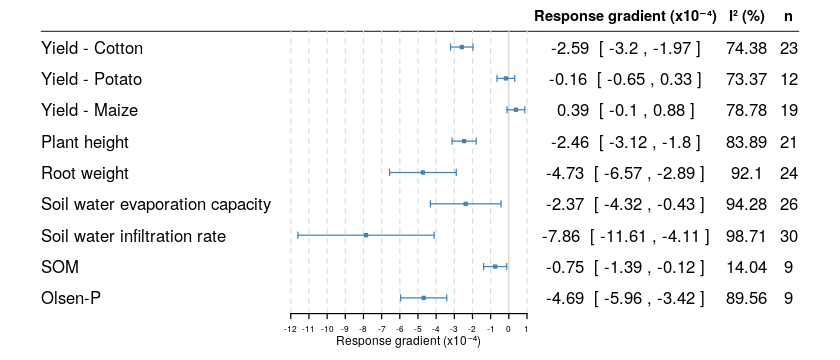

In [6]:
#set save_figures=TRUE to create a pdf file 
if(save_figures){
cairo_pdf("../figures/FigureS5.pdf", width=7, height=3)
}

#make a rectangular plot 7x3
options(repr.plot.width=7, repr.plot.height=3)


#make a data frame with mean, lower and upper 95% confidence interval bounds 
forestplot_data <- data.frame(df_s4_regression$b,df_s4_regression$lb,df_s4_regression$ub)

#make table with additional information
tabletext<-cbind(
  c(as.vector(df_s4_regression$name)),
  c(as.vector(df_s4_regression$M_label)),
  c(as.vector(df_s4_regression$I2)),
    c(as.vector(df_s4_regression$n))
   )

#create a forest plot 
forestplot(tabletext, 
           hrzl_lines = gpar(col="#444444"),
           forestplot_data,new_page = FALSE,
           txt_gp = fpTxtGp(label = gpar(fontsize=10),summary=gpar(fontsize=8),xlab=gpar(fontsize=12)),
           graph.pos = 2,
           line.margin = 1, # We need to add this to avoid crowding
           is.summary=c(as.vector(df_s4_regression$summary)),
            boxsize = .1, 
           clip=c(-Inf,Inf), 
           colgap=unit(2,"mm"),
           xlog=FALSE, 
           grid=TRUE,
           mar=unit(c(0,0,0,0),"mm"),
           #title="Meta Regression",
           xlab=as.character(df_s4_regression$M_label[1]),
            vertices = TRUE,
           graphwidth=unit(50,"mm"),
           col=fpColors(box="#4682B4",line="#4682B4", summary="#B22222")
          )
if(save_figures){
dev.off()
    }

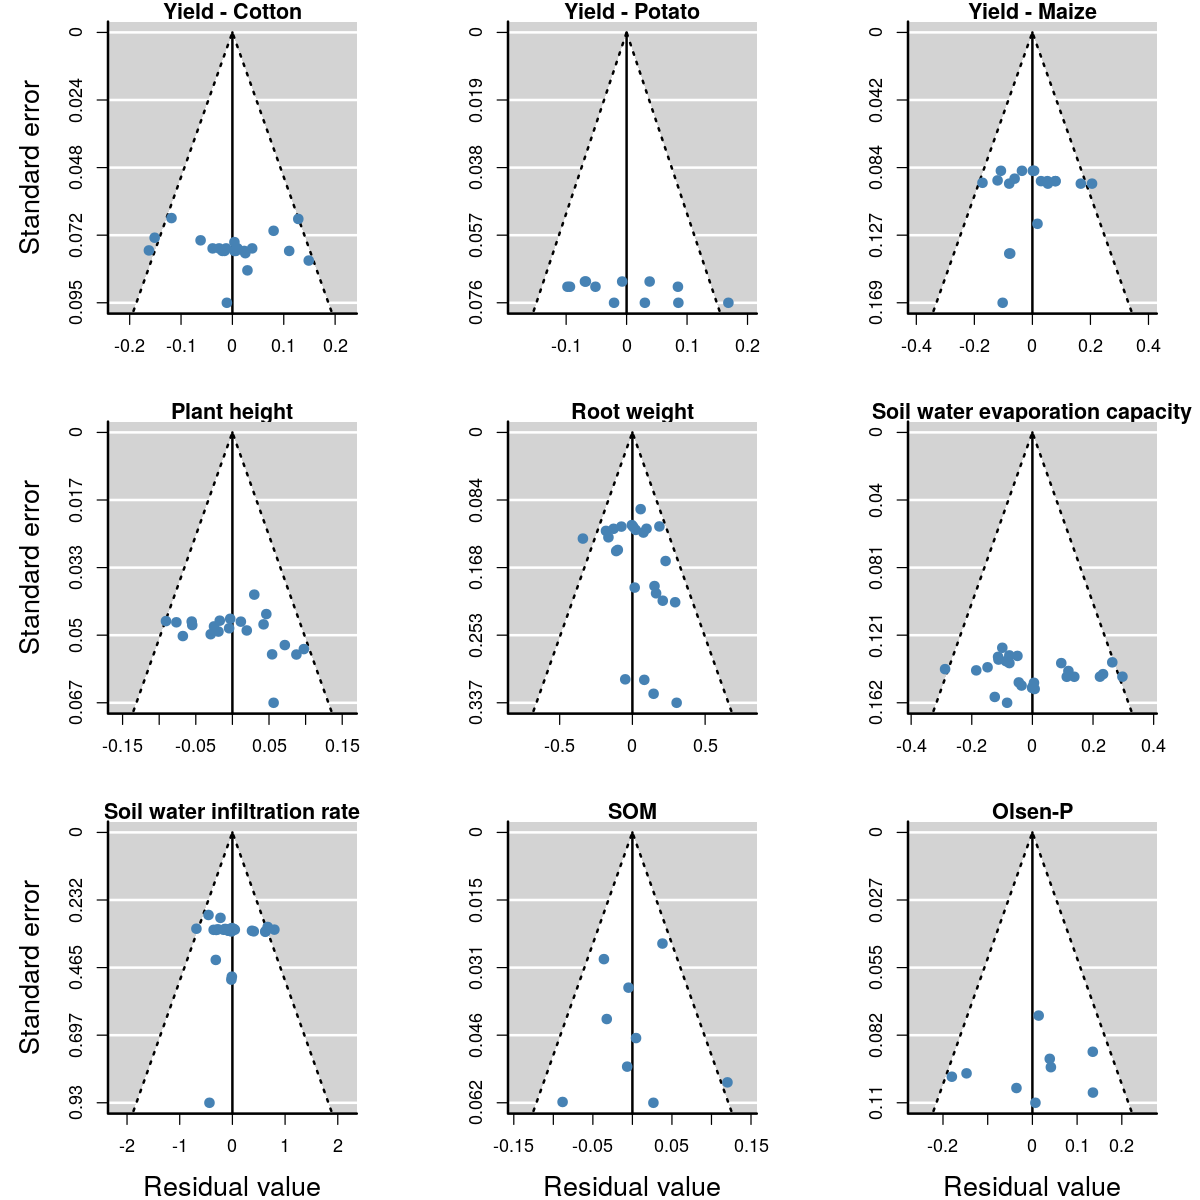

In [7]:
#set save_figures=TRUE to create a pdf file
if(save_figures){
    cairo_pdf("../figures/FigureS10.pdf", width=10, height=10)
}

#make a square plot 10x10
options(repr.plot.width=10, repr.plot.height=10)

#plot setup 
par(mfrow=c(3,3),cex = 0.9,mar=c(4,5,1,2),cex.lab=1.5,lwd=2)


#create a vector with the name of crop type 
crop_list<-c("Cotton","Potato","Maize","all","all","all","all","all","all")

#declare a vector with data set names
plot_name_list<-c(
    "Yield",               
    "Yield",               
    "Yield",                   
    "Plant height",
    "Root weight",
    "Soil water evaporation capacity",
    "Soil water infiltration rate",
    "SOM",
    "Olsen-P")


#declare a vector with input files 
file_list<-c(
    "../data/raw/Yield_t_ha_S4.csv",
    "../data/raw/Yield_t_ha_S4.csv",               
    "../data/raw/Yield_t_ha_S4.csv",                   
    "../data/raw/Plant_height_cm_S4.csv",
    "../data/raw/Root_weight_g_S4.csv",
    "../data/raw/Soil_water_evaporation_capacity_mm_S4.csv",
    "../data/raw/Soil_water_infiltration_rate_mm_min_S4.csv",
    "../data/raw/SOM_g_kg_S4.csv",
    "../data/raw/Olsen-P_mg_kg_S4.csv"
    )


#iterate the data sets 
for(i in 1:9){

    file_name<-file_list[i]
    crop<-crop_list[i]
    
    #Read input datafile 
    df<-read.csv(file=file_name, header=TRUE, sep=",")
    
    #set an index to filter the crop
    if(crop=="all")
    {
        #if crop == all use the full data set 
        indx<-rep(TRUE,nrow(df))
        plot_name<-paste(plot_name_list[i])
    }
    else{
        indx<-df$Crop_type==crop
        plot_name<-paste(plot_name_list[i],crop,sep=" - ")
    }
    
    #we use x label for the lower rows only 
    xlabel=NA
    if(i >6)
    {
        xlabel<-"Residual value"        
    }
    
    #we use y label for the first column only 
    ylabel=NA
    if(i %in% c(1,4,7))
    {
        ylabel<-"Standard error"        
    }
    
    
    #Calculate  log transformed Ratio Of Means
    dat<-escalc(measure = "ROM",m2i=CKmean,n2i=CKn,sd2i=CKsd,m1i=Tmean,n1i=Tn,sd1i=Tsd,data=df[indx,],append = TRUE)
    
    #calculate random effect meta-regression ML
    res<-rma(yi,vi,mods=~Residual_film_kg_ha,data=dat,method="ML")

    #make a funnel plot
    funnel(res,main=plot_name,xlab=xlabel, ylab=ylabel,col="#4682B4")
    
    }
if(save_figures){
dev.off()
    }

#
# 
# Meta-Regression for S4 data 
#
#
#                                   END
###################################################################################

In [8]:
###################################################################################
#                                   BEGIN
#
# 
# Meta-Analysis for S3 data 
#
#

#declare a vector with input files 
file_list<-c(
    "../data/raw/Yield_t_ha_S3.csv",
    "../data/raw/Temperature_C_S3.csv",
    "../data/raw/Soil_Water__S3.csv"
    )

#declare a vector with data set names
dataset_name_list<-c(
    "Yield",                   
    "Soil temperature",
    "Soil moisture content"
)


append_row_s3<-function(df,res,name_v,subset_v,var_v,issummary)
{
     #append a new row to df_s3 meta regression data frame
    I2<-calculate_I2(res)
    return (rbind(df, data.frame(
            name= c(name_v),
            subset= c(subset_v),
            value= c(var_v),
            summary=c(issummary),
            
            b= c(exp(res$b)),
            
            I2= c(sum(I2)),
            I2b=c(I2[1]),
            I2w=c(I2[2]),
            vb     = c(res$vb),
            lb     = c(exp(res$ci.lb)),
            ub     = c(exp(res$ci.ub)),
            n      = c(res$k),
            sigma2_1= c( res$sigma2[1]   ),
            sigma2_2= c( res$sigma2[2]   ),
            tau2=c(res$tau2),
            QEE= c(test_QEE(res$QE -(res$k-1))),
            QEp= c(res$QEp    ),
            pval= c(res$pval   ),
        
            M_label= c(make_M_label(res)) ,
            stringsAsFactors = FALSE
            )))
    
}

#create a data.frame where the first row are the name of the columns in the plot 
df_s3 <-data.frame(
    name   = c(NA),
    subset      = c("Subgroup"),
    value      = c("Category"),

    summary      = c(TRUE),

    b      = c(NA),
    I2    = c("I\u00B2 (%)"),
    I2b     = c("(between studies) I\u00B2 (%)") ,
    I2w     = c("(within studies) I\u00B2 (%)") ,
    vb     = c(NA),
    lb     = c(NA),
    ub     = c(NA),
    n      = c("n"),

    sigma2_1   = c("\u03C3\u00B2 1"),
    sigma2_2   = c("\u03C3\u00B2 2"),
    tau2= c(NA),
    QEE     = c(NA),
    QEp    = c(NA),
    pval   = c(NA),

    M_label = c("Response ratio"),
    stringsAsFactors = FALSE
)

#create a vector to set the horizontal lines of the plot (based on row role) 
hrzl_lines_list=list()

#we start at row=2 since row=1 is defined as the table header 
row_index<-2
hrzl_lines_list[[2]]<-gpar(col="#444444",lwd=2)

#iterate the data sets 
for(i in 1:3){

    file_name<-file_list[i]
    
    #Read input datafile 
    df<-read.csv(file=file_name, header=TRUE, sep=",")

    #Calculate  log transformed Ratio Of Means
    dat<-escalc(measure = "ROM",m2i=CKmean,n2i=CKn,sd2i=CKsd,m1i=Tmean,n1i=Tn,sd1i=Tsd,data=df,append = TRUE)

    #iterate each crop classification 
    for(var in unique(df$Crop_classification)){
        if(var !=""){
            #calculate random effect multi-level meta-analysis REML
            res <- rma.mv(yi, vi,random = ~1 | Reference/X, data=dat, method="REML",subset=(Crop_classification==var))           
            df_s3<-append_row_s3(df_s3,res,NA,NA,var,FALSE)
            row_index<-row_index+1
            }
        }
    
    #filter all the data with valid crop classification     
    indx=!dat$Crop_classification==""

    #SUMMARY 
    #calculate random effect multi-level meta-analysis REML
    res <- rma.mv(yi, vi,random = ~1 | Reference/X, data=dat[indx,], method="REML")           
    df_s3<-append_row_s3(df_s3,res,NA,"Crop type",NA,TRUE)
    row_index<-row_index+1
    #define a summary horizontal line at the given row index
    hrzl_lines_list[[row_index]]<-gpar(col="#444444",columns=2:7)
    
    #iterate each film type 
    for(var in unique(df$Film_type)){
        if(var !=""){
            #calculate random effect multi-level meta-analysis REML
            res <- rma.mv(yi, vi,random = ~1 | Reference/X, data=dat, method="REML",subset=(Film_type==var))           
            df_s3<-append_row_s3(df_s3,res,NA,NA,var,FALSE)
            row_index<-row_index+1
            }
        }
    
    #filter all the data with valid film type      
    indx=!dat$Film_type==""
    
    #SUMMARY 
    #calculate random effect multi-level meta-analysis REML
    res <- rma.mv(yi, vi,random = ~1 | Reference/X, data=dat[indx,], method="REML")           
    df_s3<-append_row_s3(df_s3,res,NA,"Film type",NA,TRUE)    
    row_index<-row_index+1
    #define a summary horizontal line at the given row index
    hrzl_lines_list[[row_index]]<-gpar(col="#444444",columns=2:7)
    
    #iterate each mulching cycle
    for(var in unique(df$Mulching_cycle)){
        if(var !=""){
            #calculate random effect multi-level meta-analysis REML
            res <- rma.mv(yi, vi,random = ~1 | Reference/X, data=dat, method="REML",subset=(Mulching_cycle==var))           
            if(var=="Full growing season"){
                #placing the data set name in this particular row looks good in the plot 
                df_s3<-append_row_s3(df_s3,res,dataset_name_list[i],NA,var,FALSE)                
            }
            else{
                df_s3<-append_row_s3(df_s3,res,NA,NA,var,FALSE)
            }
            row_index<-row_index+1
            }
        }
    
    #filter all the data with valid mulching cycle    
    indx=!dat$Mulching_cycle==""
    #SUMMARY 
    #calculate random effect multi-level meta-analysis REML
    res <- rma.mv(yi, vi,random = ~1 | Reference/X, data=dat[indx,], method="REML")           
    df_s3<-append_row_s3(df_s3,res,NA,"Mulching cycle",NA,TRUE)
    row_index<-row_index+1
    #define a summary horizontal line at the given row index
    hrzl_lines_list[[row_index]]<-gpar(col="#444444",columns=2:7)
    
    #iterate each mulching method
    for(var in unique(df$Mulching_method)){
        if(var !=""){
            #calculate random effect multi-level meta-analysis REML
            res <- rma.mv(yi, vi,random = ~1 | Reference/X, data=dat, method="REML",subset=(Mulching_method==var))           
            df_s3<-append_row_s3(df_s3,res,NA,NA,var,FALSE)
            row_index<-row_index+1
            }
        }
    
    #filter all the data with valid mulching method    
    indx=!dat$Mulching_method==""
    #SUMMARY 
    #calculate random effect multi-level meta-analysis REML
    res <- rma.mv(yi, vi,random = ~1 | Reference/X, data=dat[indx,], method="REML")           
    df_s3<-append_row_s3(df_s3,res,NA,"Mulching method",NA,TRUE)
    row_index<-row_index+1
    #define a summary horizontal line at the given row index
    hrzl_lines_list[[row_index]]<-gpar(col="#444444",columns=2:7)
    
    #iterate each mulching ratio
    for(var in unique(df$Mulching_ratio_class_)){
        if(var !=""){
            #calculate random effect multi-level meta-analysis REML
            res <- rma.mv(yi, vi,random = ~1 | Reference/X, data=dat, method="REML",subset=(Mulching_ratio_class_==var))           
            df_s3<-append_row_s3(df_s3,res,NA,NA,var,FALSE)
            row_index<-row_index+1
            }
        }
    
    #filter all the data with valid mulching ratio  
    indx=!dat$Mulching_ratio_class_==""
    #SUMMARY 
    #calculate random effect multi-level meta-analysis REML
    res <- rma.mv(yi, vi,random = ~1 | Reference/X, data=dat[indx,], method="REML")           
    df_s3<-append_row_s3(df_s3,res,NA,"Mulching ratio",NA,TRUE)
    row_index<-row_index+1
    #define a summary horizontal line at the given row index
    hrzl_lines_list[[row_index]]<-gpar(col="#444444",columns=2:7)

    #iterate each film thickness
    for(var in unique(df$Film_thickness_class_mm)){
        if(var !=""){
            #calculate random effect multi-level meta-analysis REML
            res <- rma.mv(yi, vi,random = ~1 | Reference/X, data=dat, method="REML",subset=(Film_thickness_class_mm==var))           
            df_s3<-append_row_s3(df_s3,res,NA,NA,var,FALSE)
            row_index<-row_index+1
            }
        }

    #filter all the data with valid film thicknes 
    indx=!dat$Film_thickness_class_mm==""
    #SUMMARY 
    #calculate random effect multi-level meta-analysis REML
    res <- rma.mv(yi, vi,random = ~1 | Reference/X, data=dat[indx,], method="REML")           
    df_s3<-append_row_s3(df_s3,res,NA,"Film thickness",NA,TRUE)
    row_index<-row_index+1
    #define a summary horizontal line at the given row index
    hrzl_lines_list[[row_index]]<-gpar(col="#444444",columns=2:7)

    #SUMMARY of summaries 
    #calculate  random effect multi-level meta-analysis REML
    res <- rma.mv(yi, vi,random = ~1 | Reference/X, data=dat, method="REML")           
    df_s3<-append_row_s3(df_s3,res,"Total",NA,NA,TRUE)
    row_index<-row_index+1
    hrzl_lines_list[[row_index]]<-gpar(col="#444444",lwd=2)
    
    }
write.csv(df_s3,"../data/metafor/meta_analysis_s3.csv")

Warning message in rma.mv(yi, vi, random = ~1 | Reference/X, data = dat, method = "REML", :
“Single-level factor(s) found in 'random' argument. Corresponding 'sigma2' value(s) fixed to 0.”

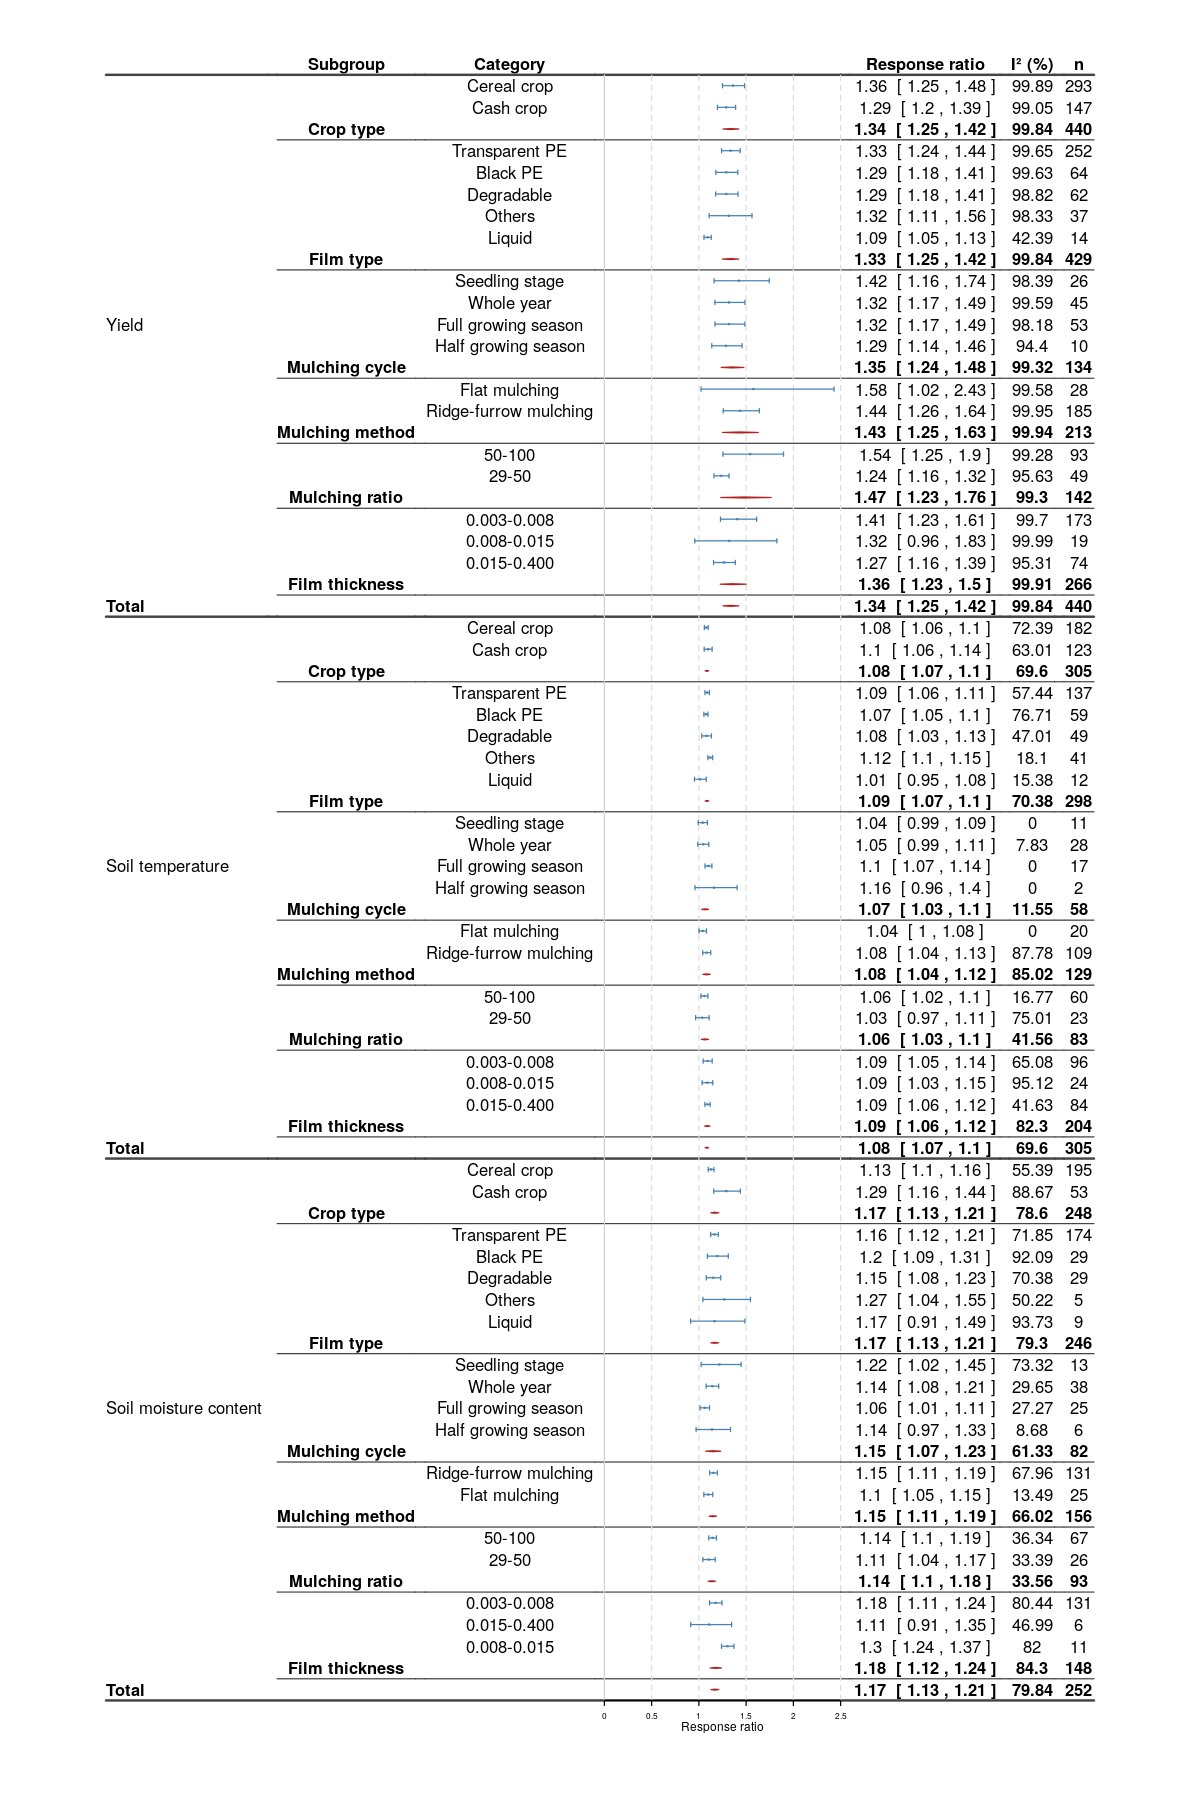

In [9]:
#set save_figures=TRUE to create a pdf file 
if(save_figures){
cairo_pdf("../figures/FigureS8.pdf", width=10, height=15)
}

#make a rectangular plot 10x15
options(repr.plot.width=10, repr.plot.height=15)

#make a data frame with mean, lower and upper 95% confidence interval bounds 
forestplot_data <- data.frame(df_s3$b,df_s3$lb,df_s3$ub)

#make table with additional information
tabletext<-cbind(
  c(as.vector(df_s3$name)),
  c(as.vector(df_s3$subset)),
  c(as.vector(df_s3$value)),
  c(as.vector(df_s3$M_label)),
  c(as.vector(df_s3$I2)),
    c(as.vector(df_s3$n))
   )

#create a forest plot 
forestplot(tabletext, 
        forestplot_data,new_page = TRUE,
           hrzl_lines=hrzl_lines_list,
           txt_gp = fpTxtGp(label = gpar(fontsize=10),summary=gpar(fontsize=9),xlab=gpar(fontsize=12)),
            graph.pos = 4,
           line.margin = .1, # We need to add this to avoid crowding
           is.summary=c(as.vector(df_s3$summary)),
            boxsize = .05, 
           clip=c(-Inf,Inf), 
           colgap=unit(2,"mm"),
           xlog=FALSE, 
           grid=TRUE,
           xlab=as.character(df_s3$M_label[1]),
            vertices = TRUE,
           graphwidth=unit(50,"mm"),
           col=fpColors(box="#4682B4",line="#4682B4", summary="#B22222")
          )
if(save_figures){
dev.off()
    }

#
# 
# Meta-Analysis for S3 data 
#
#
#                                   BEGIN
###################################################################################